In [33]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import ElasticNet
import re
%matplotlib inline

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
pitching = pd.read_csv('Pitchingdata.csv')
batting = pd.read_csv('battersdata.csv')
salaries = pd.read_csv('salariesdata.csv')

In [6]:
salaries = salaries.drop(["Pos'n", "MLS"], axis=1)

In [7]:
salaries

,Player,2017
0,"Kershaw, Clayton","$35,571,429"
1,"Greinke, Zack","$34,000,000"
2,"Price, David","$30,000,000"
3,"Hamilton, Josh","$28,410,000"
4,"Heyward, Jason","$28,166,667"
5,"Cabrera, Miguel","$28,000,000"
6,"Verlander, Justin","$28,000,000"
7,"Hernandez, Felix","$26,857,143"
8,"Pujols, Albert","$26,000,000"
9,"Sabathia, CC","$25,000,000"


In [8]:
#lets remove all of those nasty characters from our names so we can merge easily
from string import printable

batting['Name'] = batting['Name'].apply(lambda x: x.split('*',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: x.split('#',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: x.split('\\',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: re.sub("[^{}]+".format(printable), " ", x))
batting['Name'] = batting['Name'].apply(lambda x: x.split(' ',1)[-1] + ',' + ' ' + x.split(' ',1)[0])

In [9]:
batting['Name']

0             Abad, Fernando
1                Abreu, Jose
2          Adames, Cristhian
3              Adams, Austin
4                Adams, Lane
5                Adams, Matt
6                Adams, Matt
7                Adams, Matt
8                Adduci, Jim
9               Adleman, Tim
10           Adrianza, Ehire
11            Aguilar, Jesus
12               Ahmed, Nick
13            Albers, Andrew
14              Albers, Matt
15             Albies, Ozzie
16          Alburquerque, Al
17          Alburquerque, Al
18      Alcantara, Arismendy
19          Alcantara, Sandy
20          Alexander, Scott
21             Alfaro, Jorge
22           Alford, Anthony
23               Allen, Cody
24               Allen, Greg
25          Almonte, Abraham
26            Almora, Albert
27            Alonso, Yonder
28            Alonso, Yonder
29            Alonso, Yonder
                ...         
1424            Wong, Kolten
1425              Wood, Alex
1426             Wood, Blake
1427          

In [10]:
#Lets do the same thing with the pitching data
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('*',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('#',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('\\',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: re.sub("[^{}]+".format(printable), " ", x))
pitching['Name'] = pitching['Name'].apply(lambda x: x.split(' ',1)[-1] + ',' + ' ' + x.split(' ',1)[0])


In [11]:
pitching['Name']

0            Abad, Fernando
1             Adams, Austin
2              Adleman, Tim
3            Albers, Andrew
4              Albers, Matt
5          Alburquerque, Al
6          Alburquerque, Al
7          Alburquerque, Al
8           Alcantara, Raul
9          Alcantara, Sandy
10        Alcantara, Victor
11         Alexander, Scott
12              Allen, Cody
13          Almonte, Miguel
14           Altavilla, Dan
15           Alvarado, Jose
16           Alvarez, Dario
17       Alvarez, Henderson
18            Alvarez, Jose
19          Anderson, Brett
20          Anderson, Brett
21          Anderson, Brett
22          Anderson, Chase
23           Anderson, Drew
24          Anderson, Tyler
25           Andriese, Matt
26          Aoki, Norichika
27           Aquino, Jayson
28            Arano, Victor
29            Archer, Chris
               ...         
892            Winkler, Dan
893            Wisler, Matt
894          Wittgren, Nick
895    Wojciechowski, Asher
896              Woo

In [12]:
#narrow down our sample to only players with more than 200 at bats this year
batting2 = batting[batting['AB'] >= 200]

In [13]:
#narrow down our sample to only players with more than 30 games played this year
pitching2 = pitching[pitching['G'] >= 30]

In [14]:
salaries.rename(columns={'Player':'Name', '2017' : 'Salary'},inplace = True)

In [15]:
def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '').replace(' ','')
    return int(moneystring)

In [16]:
salaries['Salary'] = salaries['Salary'].apply(lambda x: money_to_int(x))

In [17]:
#lets merge our salaries dataframe with our pitching dataframe 

pitchdf = pd.merge(salaries, pitching2, on=['Name'])

In [18]:
batdf = pd.merge(salaries, batting2, on=['Name'])

In [19]:
pitchdf.corr()

,Salary,Rk,Age,W,L,W-L%,ERA,G,GS,GF,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
Salary,1.000000,0.041097,0.363977,0.425427,0.373520,0.045576,-0.032609,-0.326567,0.460613,-0.131503,...,0.226625,0.430290,0.103550,-0.050301,-0.169583,-0.059420,0.103132,-0.222511,0.073695,0.233052
Rk,0.041097,1.000000,-0.005427,0.060911,-0.014172,0.037019,-0.008532,-0.041364,0.024365,-0.105762,...,-0.138513,0.031297,0.028253,-0.054887,-0.036787,0.021655,-0.039049,-0.099684,-0.031557,0.071054
Age,0.363977,-0.005427,1.000000,-0.093316,-0.036711,-0.045041,0.010947,0.029408,-0.054531,-0.045238,...,-0.091439,-0.079763,0.030489,0.037865,-0.068385,-0.029853,0.061593,-0.077761,-0.053263,0.052529
W,0.425427,0.060911,-0.093316,1.000000,0.618835,0.319778,-0.082557,-0.454185,0.838123,-0.402657,...,0.444240,0.857497,0.011812,-0.008310,-0.121050,-0.012133,0.037295,-0.205146,-0.090287,0.054324
L,0.373520,-0.014172,-0.036711,0.618835,1.000000,-0.330239,0.250424,-0.459927,0.829906,-0.341865,...,0.420166,0.842766,-0.273936,0.237521,0.179614,0.272910,0.206914,-0.091457,-0.273008,-0.119581
W-L%,0.045576,0.037019,-0.045041,0.319778,-0.330239,1.000000,-0.344750,-0.006108,0.009963,-0.071241,...,0.004448,-0.001871,0.336358,-0.260433,-0.345669,-0.346069,-0.170488,-0.103409,0.206946,0.212898
ERA,-0.032609,-0.008532,0.010947,-0.082557,0.250424,-0.344750,1.000000,-0.350745,0.171282,-0.239228,...,0.089720,0.112851,-0.856268,0.742343,0.781724,0.741734,0.634013,0.299239,-0.387682,-0.465063
G,-0.326567,-0.041364,0.029408,-0.454185,-0.459927,-0.006108,-0.350745,1.000000,-0.660741,0.505606,...,-0.204094,-0.514252,0.265424,-0.326520,-0.217089,-0.294939,-0.325643,0.055398,0.248043,0.111098
GS,0.460613,0.024365,-0.054531,0.838123,0.829906,0.009963,0.171282,-0.660741,1.000000,-0.520920,...,0.453394,0.973174,-0.199929,0.203646,0.087048,0.206504,0.202017,-0.159473,-0.258273,-0.058648
GF,-0.131503,-0.105762,-0.045238,-0.402657,-0.341865,-0.071241,-0.239228,0.505606,-0.520920,1.000000,...,-0.134415,-0.460222,0.251434,-0.282397,-0.212774,-0.247451,-0.209293,-0.010931,0.277292,0.200441


In [20]:
# Define the model
lm1 = smf.ols('Salary ~ Age + W + ERA + GS + CG + SV + BB + BK', data=pitchdf)

# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     25.70
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           6.01e-29
Time:                        10:45:12   Log-Likelihood:                -4372.8
No. Observations:                 264   AIC:                             8764.
Df Residuals:                     255   BIC:                             8796.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.112e+07   2.41e+06     -4.621      0.000   -1.59e+07   -6.38e+06
Age         5.191e+05   6.58e+04      7.893      0.000     3.9e+05    6.49e+05
W           1.813e+05   1.16e+05      1.563      0.119   -4.71e+04     4.1e+05
ERA        -1.211e+05    2.3e+05     -0.525      0.600   -5.75e+05    3.33e+05
GS            2.7e+05   5.23e+04      5.161      0.000    1.67e+05    3.73e+05
CG          8.282e+05   5.84e+05      1.418      0.158   -3.22e+05    1.98e+06
SV          8.446e+04   2.74e+04      3.085      0.002    3.06e+04    1.38e+05
BB         -9.315e+04   2.85e+04     -3.270      0.001   -1.49e+05    -3.7e+04
BK         -7.221e+05   4.36e+05     -1.656      0.099   -1.58e+06    1.37e+05
==============================================================================
Omnibus:                       89.210   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.414
Skew:                           1.400   Prob(JB):                     3.58e-71
Kurtosis:                       7.653   Cond. No.                         465.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
batdf.corr()

,Salary,Rk,Age,G,PA,AB,R,H,2B,3B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
Salary,1.000000,0.009165,0.606202,0.057504,0.199296,0.180593,0.192008,0.184080,0.163628,-0.078453,...,0.170560,0.106089,0.138851,0.138511,0.178454,0.260412,-0.002797,-0.148869,0.147787,0.180983
Rk,0.009165,1.000000,0.004546,-0.065926,-0.033501,-0.035515,-0.047072,-0.053329,-0.004656,-0.132165,...,-0.077681,-0.087793,-0.091792,-0.097174,-0.047042,-0.023124,-0.011260,-0.091515,-0.045647,0.000577
Age,0.606202,0.004546,1.000000,-0.146109,-0.107722,-0.121843,-0.130538,-0.142844,-0.099314,-0.205392,...,-0.029266,-0.116870,-0.095293,-0.095071,-0.157288,0.056443,0.027722,-0.069463,0.003855,-0.111252
G,0.057504,-0.065926,-0.146109,1.000000,0.908129,0.902582,0.780707,0.823041,0.697852,0.296253,...,0.228776,0.223291,0.245050,0.239226,0.806410,0.494880,0.265290,0.058459,0.422807,0.353129
PA,0.199296,-0.033501,-0.107722,0.908129,1.000000,0.991061,0.895783,0.936471,0.783408,0.318975,...,0.340749,0.336996,0.368106,0.370215,0.920396,0.558754,0.292341,-0.047802,0.455857,0.396234
AB,0.180593,-0.035515,-0.121843,0.902582,0.991061,1.000000,0.866479,0.946711,0.782886,0.331467,...,0.261274,0.303571,0.315069,0.315806,0.910363,0.574064,0.252583,-0.025995,0.443205,0.345420
R,0.192008,-0.047072,-0.130538,0.780707,0.895783,0.866479,1.000000,0.881960,0.747226,0.380453,...,0.532521,0.537904,0.583409,0.578175,0.920152,0.435305,0.300301,-0.097788,0.339565,0.428918
H,0.184080,-0.053329,-0.142844,0.823041,0.936471,0.946711,0.881960,1.000000,0.813323,0.360725,...,0.453825,0.441419,0.484967,0.488564,0.932378,0.584283,0.242538,-0.036524,0.432712,0.387063
2B,0.163628,-0.004656,-0.099314,0.697852,0.783408,0.782886,0.747226,0.813323,1.000000,0.206357,...,0.384632,0.444826,0.462474,0.451384,0.809504,0.467441,0.199402,-0.099285,0.409154,0.372071
3B,-0.078453,-0.132165,-0.205392,0.296253,0.318975,0.331467,0.380453,0.360725,0.206357,1.000000,...,0.138567,0.072635,0.103030,0.084883,0.290800,-0.068892,0.094229,0.197076,0.027010,0.089816


In [22]:
# Define the model
lm2 = smf.ols('Salary ~ Age + G + PA + RBI + SO', data=batdf)

# Fit the model
fit2 = lm2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     64.51
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           4.35e-46
Time:                        10:45:13   Log-Likelihood:                -5339.3
No. Observations:                 318   AIC:                         1.069e+04
Df Residuals:                     312   BIC:                         1.071e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.568e+07   2.71e+06     -9.464      0.000    -3.1e+07   -2.03e+07
Age         1.095e+06   7.46e+04     14.678      0.000    9.48e+05    1.24e+06
G          -1.187e+05   2.42e+04     -4.893      0.000   -1.66e+05   -7.09e+04
PA          3.118e+04   5500.468      5.668      0.000    2.04e+04     4.2e+04
RBI         5.174e+04   1.83e+04      2.833      0.005    1.58e+04    8.77e+04
SO          -2.82e+04      1e+04     -2.812      0.005   -4.79e+04   -8469.957
==============================================================================
Omnibus:                       71.901   Durbin-Watson:                   0.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.388
Skew:                           1.161   Prob(JB):                     9.89e-33
Kurtosis:                       5.394   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
#These are not the best fits so lets try again with logSalary
pitchdf['log_salary'] = np.log(pitchdf.Salary)
batdf['log_salary'] = np.log(batdf.Salary)

In [24]:
# Define the model
lm3 = smf.ols('log_salary ~ Age + W + GS + ERA + CG + SV + BB + BK', data=pitchdf)

# Fit the model
fit3 = lm3.fit()
# Print summary statistics of the model's performance
fit3.summary()
#As we can see this is infact a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     32.87
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           2.80e-35
Time:                        10:45:13   Log-Likelihood:                -321.11
No. Observations:                 264   AIC:                             660.2
Df Residuals:                     255   BIC:                             692.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4186      0.520     18.115      0.000       8.395      10.442
Age            0.1707      0.014     12.009      0.000       0.143       0.199
W              0.0135      0.025      0.540      0.590      -0.036       0.063
GS             0.0568      0.011      5.027      0.000       0.035       0.079
ERA            0.0056      0.050      0.112      0.911      -0.092       0.104
CG             0.1026      0.126      0.813      0.417      -0.146       0.351
SV             0.0250      0.006      4.220      0.000       0.013       0.037
BB            -0.0154      0.006     -2.495      0.013      -0.027      -0.003
BK            -0.2148      0.094     -2.279      0.023      -0.400      -0.029
==============================================================================
Omnibus:                        5.203   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                3.348
Skew:                          -0.082   Prob(JB):                        0.187
Kurtosis:                       2.473   Cond. No.                         465.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Define the model
lm4 = smf.ols('log_salary ~ Age + G + PA + RBI + SO', data=batdf)

# Fit the model
fit4 = lm4.fit()
# Print summary statistics of the model's performance
fit4.summary()
#again we can see that this is a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     100.7
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           6.04e-63
Time:                        10:45:13   Log-Likelihood:                -390.04
No. Observations:                 318   AIC:                             792.1
Df Residuals:                     312   BIC:                             814.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9664      0.472     16.868      0.000       7.037       8.896
Age            0.2413      0.013     18.584      0.000       0.216       0.267
G             -0.0259      0.004     -6.136      0.000      -0.034      -0.018
PA             0.0071      0.001      7.374      0.000       0.005       0.009
RBI            0.0081      0.003      2.540      0.012       0.002       0.014
SO            -0.0064      0.002     -3.691      0.000      -0.010      -0.003
==============================================================================
Omnibus:                        0.998   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.028
Skew:                          -0.034   Prob(JB):                        0.598
Kurtosis:                       2.730   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
batdf.columns


Index(['Name', 'Salary', 'Rk', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG',
       'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'Pos Summary',
       'log_salary'],
      dtype='object')

In [61]:
# Define the model
y = batdf['log_salary']
X = batdf.drop(['log_salary', 'Salary', 'Pos\xa0Summary', 'Tm', 'Name', 'Lg'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rcv = RidgeCV(cv=10)
# Fit the model
rfit = rcv.fit(X,y)
# Print summary statistics of the model's performance
rfit.score(X_test, y_test)
#again we can see that this is a better fit.

0.60534055000390063

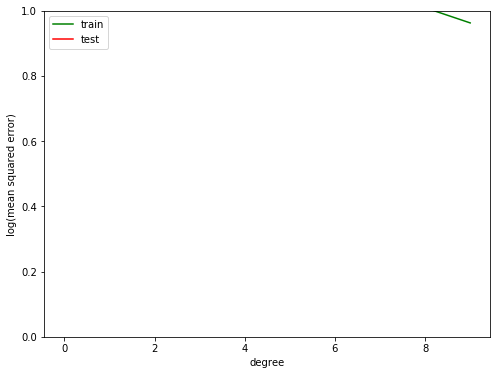

In [89]:
from sklearn.metrics import mean_squared_error

X = pitchdf[['GS']]
y = pitchdf['log_salary']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)





# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')

In [90]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

x_plot = np.linspace(0, 1, 100)

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1001041679387136e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1062995406352147e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)


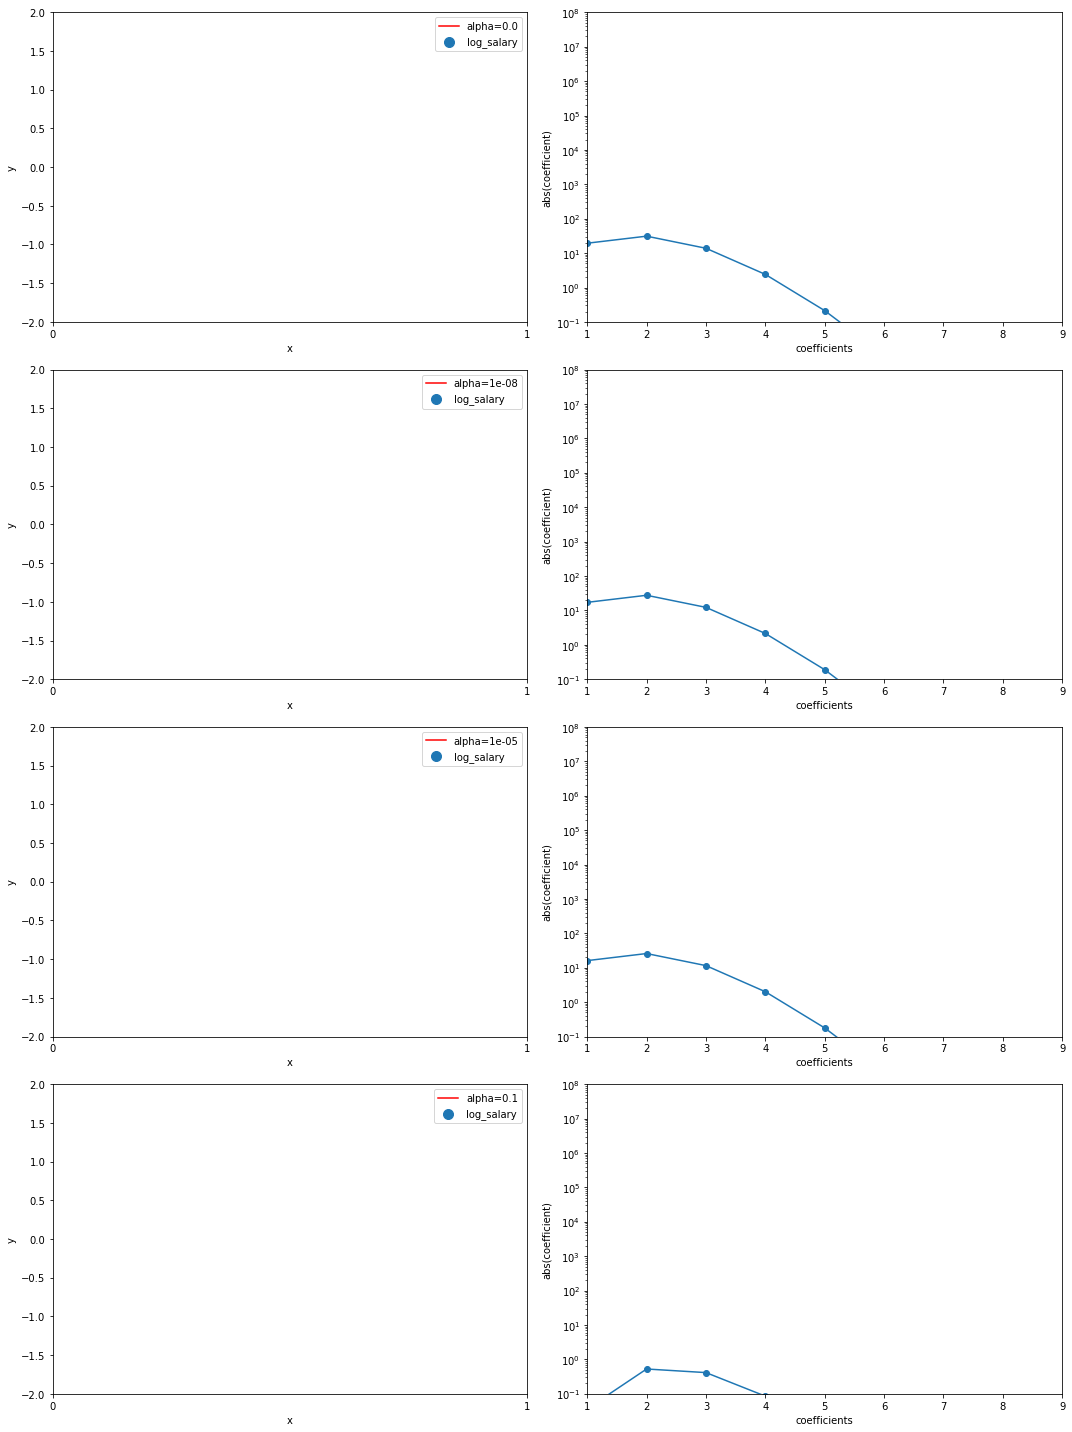

In [91]:
from sklearn.linear_model import Ridge

fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

# Try out 4 different values of the RidgeRegression parameter alpha and watch how the resulting models change
# With higher values of alpha, more complex (more wiggly) models will be more punished and thus less likely
degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

In [ ]:
#lets attempt to model over the whole career instead of looking at just one year.

master = pd.read_csv('Master.csv')
master = master.drop(['birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'deathYear','deathMonth', 'deathDay','deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height','debut','finalGame','retroID','bbrefID'], axis = 1)

In [ ]:
battingc = pd.read_csv('Batting.csv')
pitchingc = pd.read_csv('Pitching.csv')
salariesc = pd.read_csv('Salaries.csv')

In [ ]:
salariesc = salariesc.drop(['lgID', 'teamID'], axis = 1)

In [ ]:
#we need to combine our data frames.  To do this we will merge on their player id.

#pitchcdf = pd.merge(salariesc, pitchingc, on=['playerID', 'yearID'])
#batcdf = pd.merge(salariesc, battingc, on=['playerID', 'yearID'])

In [ ]:
pitchc2df = pd.merge(master, battingc, on='playerID')
batc2df = pd.merge(master,pitchingc, on='playerID')

In [ ]:
p_age = pitchc2df['yearID'].sub(pitchc2df['birthYear'], axis=0)
pitchc2df = pitchc2df.assign(p_age=p_age.values)

In [ ]:
b_age = batc2df['yearID'].sub(batc2df['birthYear'], axis=0)
batc2df = batc2df.assign(b_age=b_age.values)

In [ ]:
careerbatdf = batc2df[batc2df['birthYear'] >= 1971]

In [ ]:
careerbatdf = careerbatdf.groupby(['playerID','yearID']).sum()

In [ ]:
careerbatdf.info()

In [ ]:
for name in careerbatdf.index:
    print(name)

In [ ]:
careerbatdf.loc['adlemti01']

In [ ]:
maxsal = salariesc.groupby(['playerID','yearID']).agg(lambda x: max(x))

In [ ]:
f = salariesc.groupby(['playerID', 'salary']).max()

In [ ]:
maxsal.loc['aardsda01']

In [ ]:
maxsal

In [ ]:
batc3df = batc2df[batc2df['birthYear'] >= 1972]

In [ ]:
career_batdf = batc3df.groupby(['playerID']).sum()
#career_pitchdf = 

In [ ]:
career_batdf

In [ ]:
career_batdf2 = career_batdf[career_batdf['G'] >= 40]

In [ ]:
career_batdf2 = career_batdf2[career_batdf2['birthYear'] >= 1972]

In [ ]:

career_batdf2['log_salary'] = np.log(career_batdf2.salary)

In [ ]:
career_batdf2.corr()

In [ ]:
# Define the model
lm5 = smf.ols('salary ~ b_age + AB + R + H + HR +  RBI + SO + BB', data=career_batdf2)

# Fit the model
fit5 = lm5.fit()
# Print summary statistics of the model's performance
fit5.summary()


In [ ]:
# Define the model
lm6 = smf.ols('log_salary ~ b_age + AB + H + HR + SO + BB', data=career_batdf2)

# Fit the model
fit6 = lm6.fit()
# Print summary statistics of the model's performance
fit6.summary()

